# Fleet Aging Calculation in Brazil

This script tries to calculate the minimum mean age of trucks in Brazil's fleet. We start with a graphic showing how vehicle sales, traffic and outstanding fleet performed historically. Afterwards we show the distribution of current fleet trucks by emission lagislation. Then we use the outstanding fleet number and vehicle sales to calculate the minimum fleet age.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib
from datetime import datetime
import statistics

In [160]:
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# WorldBank population in Brazil
population = pd.read_excel('https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel', skiprows = 3)
population[population['Country Name'] == 'Brazil']

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
27,Brazil,BRA,"Population, total",SP.POP.TOTL,72179226.0,74311343.0,76514328.0,78772657.0,81064571.0,83373530.0,...,197514534.0,199287296.0,201035903.0,202763735.0,204471769.0,206163058.0,207833831.0,209469333.0,211049527.0,NaN


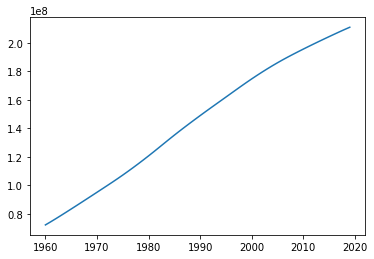

In [181]:
population_dict = {}
for year in range(1960,2020):
    population_dict.update({year:population.loc[population['Country Name'] == 'Brazil',str(year)][27]})
plt.plot(list(population_dict.keys()),list(population_dict.values()))

## Parsing ANFAVEA Data

In [7]:
licensed_vehicles_data = pd.read_excel('https://anfavea.com.br/docs/SeriesTemporais_Autoveiculos.xlsm',
                                       skiprows = 3, usecols = ['Unnamed: 0','AUTOMÓVEIS','CAMINHÕES','ÔNIBUS'])
licensed_vehicles_data

,Unnamed: 0,AUTOMÓVEIS,CAMINHÕES,ÔNIBUS
0,NaT,Licenciamento Total,Licenciamento Total,Licenciamento Total
1,1957-01-01,758,1037,110
2,1957-02-01,624,1262,98
3,1957-03-01,817,1706,146
4,1957-04-01,722,1525,178
...,...,...,...,...
776,2021-08-01,0,0,0
777,2021-09-01,0,0,0
778,2021-10-01,0,0,0
779,2021-11-01,0,0,0


In [225]:
licensed_vehicles_trucks_full_dict = {}
years = list(range(1960,2021))
for year in years:
    total = 0
    for index, row in licensed_vehicles_data[1:].iterrows():
        if str(year) in row['Unnamed: 0'].strftime("%H:%M:%S.%f - %b %d %Y"):
            total = total + int(row['CAMINHÕES'])
    #pop = population.loc[population['Country Name'] == 'Brazil',str(year)]
    #licensed_vehicles_trucks_percapita_full_dict.update({year:100000*total/pop})
    licensed_vehicles_trucks_full_dict.update({year:total})
values = []
for item in licensed_vehicles_trucks_full_dict.values():
    #values.append(item[27])
    values.append(item)

### Legislation changes source
http://www.anfavea.com.br/documentos/SeminarioItem1.pdf

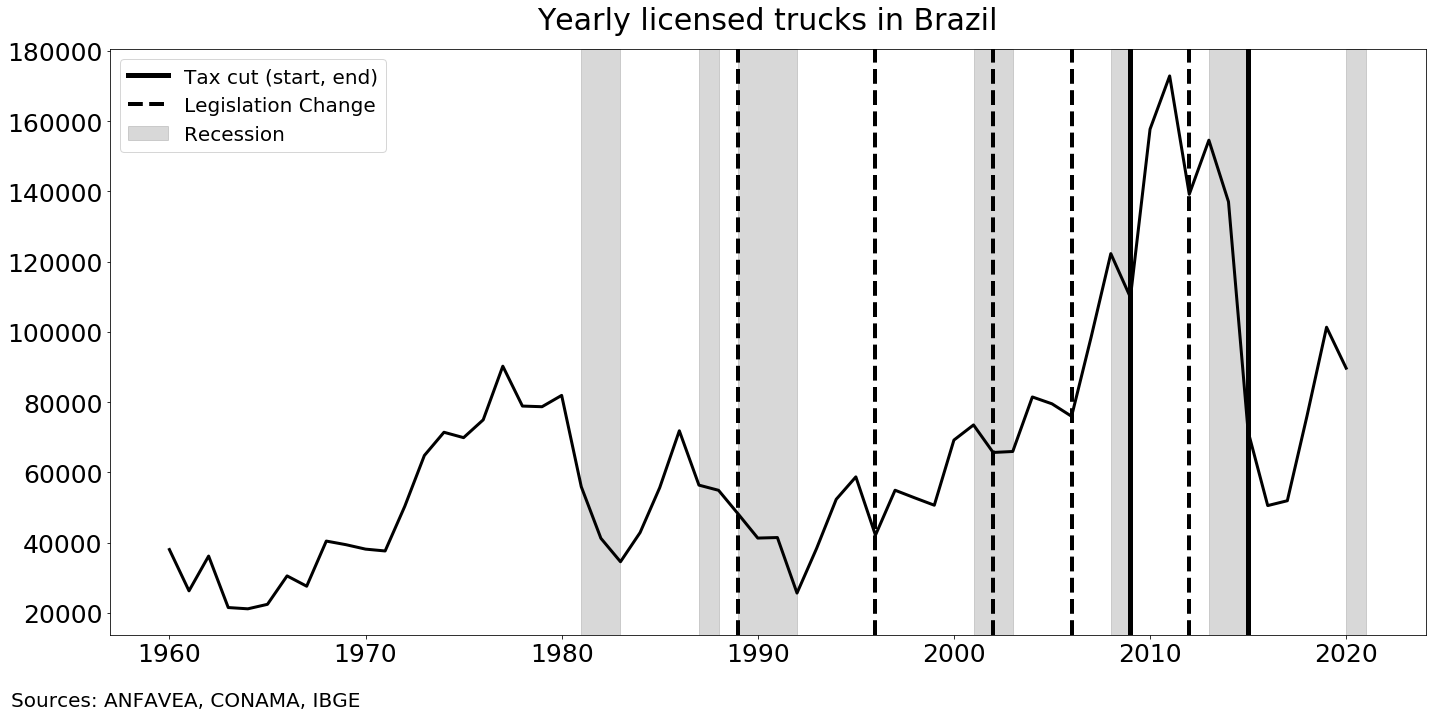

In [226]:
# Create some mock data
t = list(licensed_vehicles_trucks_full_dict.keys())
data1 = values

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'black'
#ax1.set_xlabel('(years)', size=25)
ax1.xaxis.set_label_coords(1.04, -0.015)
#ax1.set_ylabel('Licensed trucks', color=color, size=30)
ax1.plot(t, data1, color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=25)
ax1.tick_params(axis='x', labelcolor=color, labelsize=25)

ax1.axvline(x=2009, color='black', label = 'Tax cut (start, end)', linewidth = 5)
ax1.axvline(x=2015, color='black', linewidth = 5)

ax1.axvline(x=2012, color='black', label = 'Legislation Change', linewidth = 4, ls = '--')
ax1.axvline(x=2006, color='black', linewidth = 4, ls = '--')
ax1.axvline(x=2002, color='black', linewidth = 4, ls = '--')
ax1.axvline(x=1996, color='black', linewidth = 4, ls = '--')
ax1.axvline(x=1989, color='black', linewidth = 4, ls = '--')

ax1.axvspan(1981, 1983,label="Recession",color="grey", alpha=0.3)
ax1.axvspan(1987, 1988,color="grey", alpha=0.3)
ax1.axvspan(1989, 1992,color="grey", alpha=0.3)
ax1.axvspan(2001, 2003,color="grey", alpha=0.3)
ax1.axvspan(2008, 2009,color="grey", alpha=0.3)
ax1.axvspan(2013, 2015,color="grey", alpha=0.3)
ax1.axvspan(2020, 2021,color="grey", alpha=0.3)

ax1.legend(prop={"size":20})
plt.title('Yearly licensed trucks in Brazil', size= 30, pad=20)
ax1.text(-0.075, -0.12, 'Sources: ANFAVEA, CONAMA, IBGE',transform=ax1.transAxes,
        fontsize = 20) 

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Parsing ANTT Data

In [61]:
traffic_dict_data = {}
traffic_dict_data.update({2010:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/100a4393-6f63-467f-a685-e0a545e099bf/download/volume_praca_2010.json',
                          2011:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/079a1f44-6e2f-466b-b9ac-553fa15e40ad/download/volume_praca_2011.json',
                          2012:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/fdc4184b-b45a-4675-8dd4-3b7a40a45bea/download/volume_praca_2012.json',
                          2013:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/3dff101f-f91d-4231-87f8-0a5ee6dc2223/download/volume_praca_2013.json',
                          2014:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/3a290d3f-4316-4fb7-8055-bffd11f054ef/download/volume_praca_2014.json',
                          2015:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/577bc0be-fe5f-41c8-a1c1-7e18b5cdd097/download/volume_praca_2015.json',
                          2016:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/6208337e-97c9-4a0e-8698-dfe0aa3888a7/download/volume_praca_2016.json',
                          2017:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/0e6ecad7-4c47-4500-a9e4-2decfd6a770d/download/volume_praca_2017.json',
                          2018:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/dc1cacb7-c164-4a6d-87e2-d2e057f3bfb7/download/volume_praca_2018.json',
                          2019:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/312017b9-b7aa-4e69-a85d-c61546b4292c/download/volume_praca_2019.json',
                          2020:'https://dados.antt.gov.br/dataset/5bf70ec3-b24e-4f73-99a0-78b200f5e915/resource/eb2b4691-be9d-442c-abbd-44e570ca2cdc/download/volume_praca_2020.json'})

In [62]:
dataframe = pd.read_json(traffic_dict_data[int(2010)])
dataframe['empresas_habilitadas_regular'][0]

{'Concessionaria': '12.Rodovia do Aço',
 'mes_ano': 'Jan-10',
 'Sentido': 'Norte',
 'Praca': 'Praça 01  BR-393/RJ km 125,00',
 'Categoria': 'Categoria 1',
 'Tipo_de_veiculo': 'Passeio',
 'Volume_total': '44146'}

In [155]:
traffic_comercial_dict = {}
for year in range(2010,2019):
    print('-',end = '')
    dataframe = pd.read_json(traffic_dict_data[int(year)])
    total = 0
    for places in dataframe['empresas_habilitadas_regular']:
        if places['Tipo_de_veiculo'] == 'Comercial':
            if ',' in places['Volume_total']:
                total = total + int(float(places['Volume_total'].replace(',','.')))
            else:
                total = total + int(float(places['Volume_total']))
        traffic_comercial_dict.update({year:total})
traffic_comercial_dict

---------

{2010: 129259705,
 2011: 140332635,
 2012: 141659187,
 2013: 159539476,
 2014: 165273984,
 2015: 180257418,
 2016: 200242135,
 2017: 199689873,
 2018: 200701354}

In [164]:
fleet_dataset = pd.read_excel('Frota de veículos - Brasil.xls', skiprows =[1,2,27])
total_fleet_dict = {}
for year in range(2010,2019):
    total_fleet_dict.update({year:fleet_dataset[year][2]})
total_fleet_dict

{2010: 2143467.0,
 2011: 2274947.0,
 2012: 2380780.0,
 2013: 2488680.0,
 2014: 2588984.0,
 2015: 2645992.0,
 2016: 2684227.0,
 2017: 2720548.0,
 2018: 2766097.0}

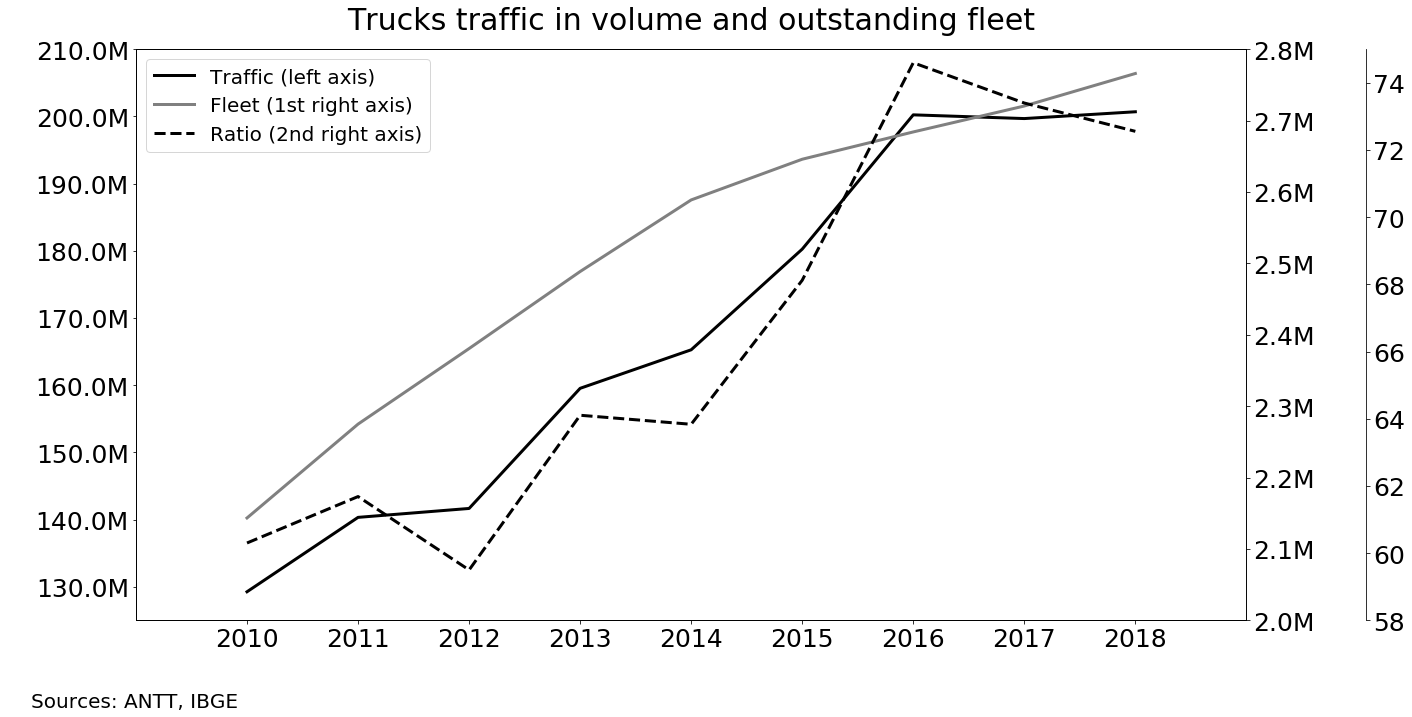

In [197]:
fig, host = plt.subplots(figsize=(20,10)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)

t = list(total_fleet_dict.keys())
data1 = list(traffic_comercial_dict.values())
data2 = list(total_fleet_dict.values())
#data3 = list(population_dict.values())
data3 = []
for year in range(2010,2019):
    data3.append(traffic_comercial_dict[year]/total_fleet_dict[year])

par1 = host.twinx()
par2 = host.twinx()

host.get_yaxis().get_major_formatter().set_scientific(False)
#host.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#par1.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
host.yaxis.set_major_formatter(formatter)
par1.yaxis.set_major_formatter(formatter)

host.set_xlim(2009, 2019)
host.set_ylim(125000000, 210000000)
par1.set_ylim(2000000, 2800000)
par2.set_ylim(58, 75)
#par2.set_ylim(195000000, 210000000)

p1, = host.plot(t, data1, color='black', label="Traffic (left axis)", linewidth = 3)
p2, = par1.plot(t, data2, color='grey', label="Fleet (1st right axis)", linewidth = 3)
p3, = par2.plot(t, data3, color='black', label="Ratio (2nd right axis)", linewidth = 3, ls = '--')

#host.xaxis.set_label_coords(1.04, -0.015)
host.tick_params(axis='x', labelcolor='black', labelsize=25)
host.tick_params(axis='y', labelcolor='black', labelsize=25)
par1.tick_params(axis='y', labelcolor='black', labelsize=25)
par2.tick_params(axis='y', labelcolor='black', labelsize=25)

lns = [p1, p2, p3]
host.legend(handles=lns, loc='upper left', fontsize = 20)

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 120))

# no x-ticks                 
par2.xaxis.set_ticks(t)

# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

# Move "Velocity"-axis to the left
# par2.spines['left'].set_position(('outward', 60))
# par2.spines['left'].set_visible(True)
# par2.yaxis.set_label_position('left')
# par2.yaxis.set_ticks_position('left')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.title('Trucks traffic in volume and outstanding fleet', size= 30, pad=20)
host.text(-0.05, -0.12, 'Sources: ANTT, IBGE',transform=ax1.transAxes,
        fontsize = 20) 

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)
plt.show()

In [221]:
max_fleet = total_fleet_dict[2018]
print(max_fleet)
total_fleet_dict

2766097.0


{2010: 2143467.0,
 2011: 2274947.0,
 2012: 2380780.0,
 2013: 2488680.0,
 2014: 2588984.0,
 2015: 2645992.0,
 2016: 2684227.0,
 2017: 2720548.0,
 2018: 2766097.0}

## Outstanding Fleet by PROCONVE PHASE

In [219]:
Legislations = {'P7':range(2012,2019),'P5':range(2005,2012),'P4':range(2000,2005),
                'P2':range(1996,2000),'P1':range(1989,1996),'No P':range(1960,1989)}
legislations_dist = {}
total = 0
fleet_cur = 0
for legislation in Legislations:
    total = 0
    for year in reversed(Legislations[legislation]):
        #print(year)
        for index, row in licensed_vehicles_data[1:].iterrows():
            if str(year) in row['Unnamed: 0'].strftime("%H:%M:%S.%f - %b %d %Y") and fleet_cur < max_fleet:
                total = total + int(row['CAMINHÕES'])
                fleet_cur = fleet_cur + int(row['CAMINHÕES'])
    legislations_dist.update({legislation:total})
print(fleet_cur)

2768517


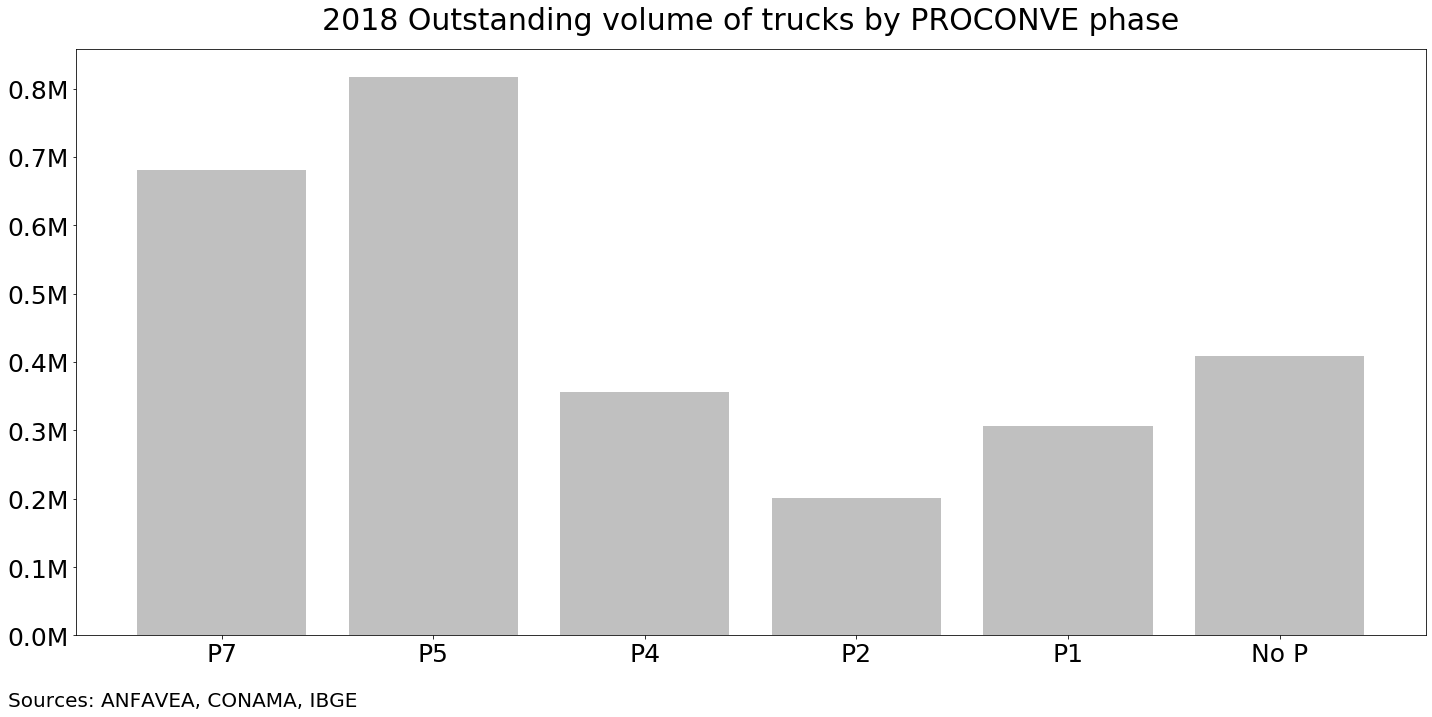

In [248]:
t = list(legislations_dist.keys())
data1 = list(legislations_dist.values())

fig, ax1 = plt.subplots(figsize=(20, 10))

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax1.yaxis.set_major_formatter(formatter)

color = 'silver'
#ax1.set_xlabel('Years', size=30)
ax1.xaxis.set_label_coords(1.05, -0.025)
#ax1.set_ylabel('Licensed trucks', color=color, size=30)
ax1.bar(t, data1, color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor='black', labelsize=25)
ax1.tick_params(axis='x', labelcolor='black', labelsize=25)

plt.title('2018 Outstanding volume of trucks by PROCONVE phase', size= 30, pad=20)
ax1.text(-0.05, -0.12, 'Sources: ANFAVEA, CONAMA, IBGE',transform=ax1.transAxes,
        fontsize = 20)

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)
plt.show()

## Estimating fleet ageing in Brazil

In [251]:
mean_year_dict = {}
for year1 in range(2010,2019):
    total = total_fleet_dict[year1]
    #print(year1,total)
    total_sold = 0
    mean_year = 0
    for year2 in reversed(range(1970,year1+1)):
        if total_sold + licensed_vehicles_trucks_full_dict[year2] < total:
            total_sold = total_sold + licensed_vehicles_trucks_full_dict[year2]
            mean_year = mean_year + year2*int(licensed_vehicles_trucks_full_dict[year2])/total
        elif total - total_sold > 0:
            mean_year = mean_year + year2*(total - total_sold)/total
            total_sold = total_sold + licensed_vehicles_trucks_full_dict[year2]
    mean_year_dict.update({year1:year1-mean_year})

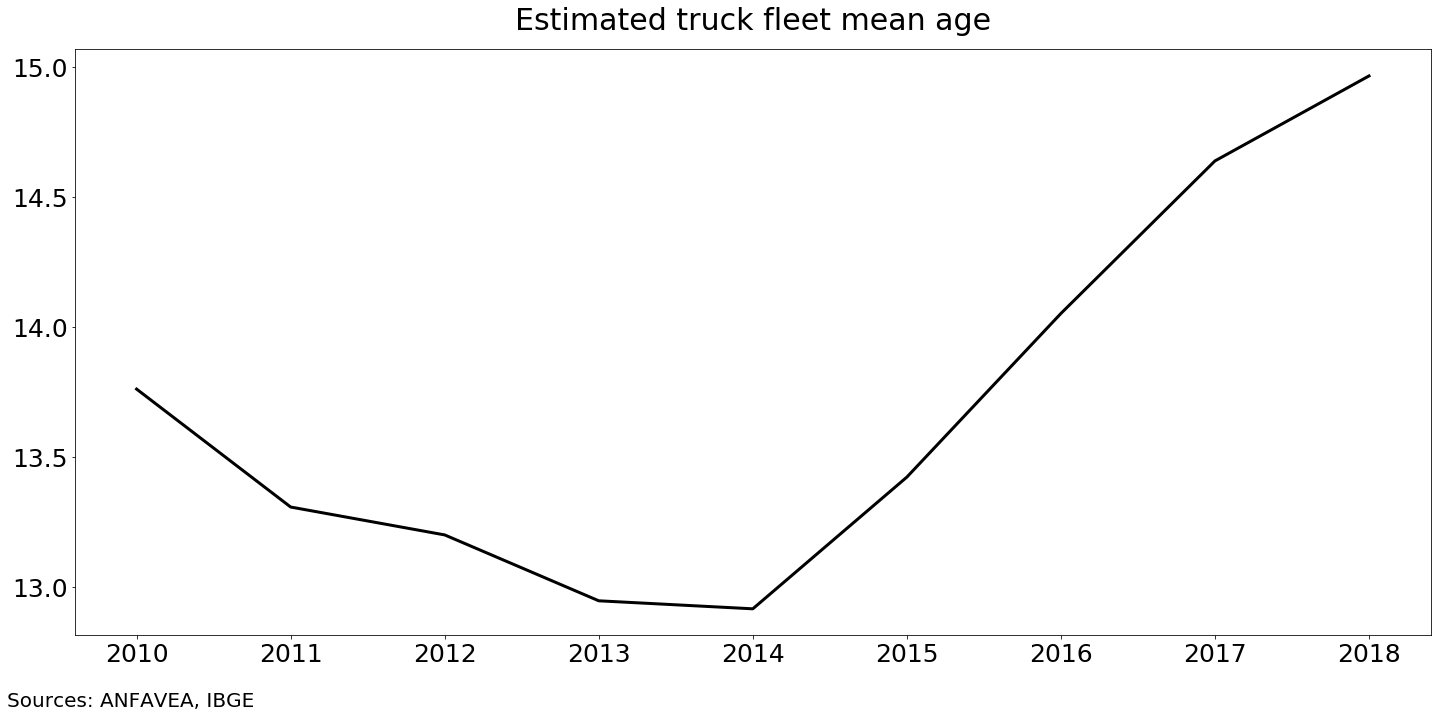

In [253]:
t = list(mean_year_dict.keys())
data1 = list(mean_year_dict.values())

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'black'
#ax1.set_xlabel('(years)', size=25)
ax1.xaxis.set_label_coords(1.04, -0.015)
#ax1.set_ylabel('Licensed trucks', color=color, size=30)
ax1.plot(t, data1, color=color, linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color, labelsize=25)
ax1.tick_params(axis='x', labelcolor=color, labelsize=25)

plt.title('Estimated truck fleet mean age', size= 30, pad=20)
ax1.text(-0.05, -0.12, 'Sources: ANFAVEA, IBGE',transform=ax1.transAxes,
        fontsize = 20)

# Adjust spacings w.r.t. figsize
fig.tight_layout()
# Alternatively: bbox_inches='tight' within the plt.savefig function 
#                (overwrites figsize)
plt.show()